In [14]:
from pythtb_Wannier import *
from pythtb import *
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy

### Diagonalizing model

In [15]:
delta = 1
t0 = 0.1
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

# adding disorder
# J = 2
# J_site = 2
# model.set_onsite(J, ind_i = J_site, mode='add')

# model.display()

In [16]:
# 2D k-mesh
nkx = 24
nky = 24
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

Reporting Chern number


In [17]:
u_wfs_full = wf_array(model, [nkx, nky])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print("Chern number: ", chern)

Chern number:  1.0160105232452901e-16


#### Plotting bands

In [18]:
# k_path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
# k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
# title = title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$")

# plot.plot_bands(
#     model, k_path=k_path, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

#### Wannierizing

Don't want to use `solve_on_grid()`, since the we want a to exclude the endpoint.

Note: `solve_on_grid()` is equivalent to using `solve_on_point()` over the entire BZ (inclusive) and using `impose_pbc()` on all periodic directions

In [19]:
u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

Define trial functions and Wannierize

In [20]:
omit = False
omit_site = 4

if omit:
    tf_list = list(np.setdiff1d(low_E_sites, [omit_site])) # delta on lower energy sites omitting the last site
else:
    tf_list = list(low_E_sites) # delta on lower energy sites

In [21]:
w0 = Wannierize(model, u_wfs_Wan, tf_list)

## Plotting

([<Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 1 Axes>],
 [<Axes: title={'center': "$C =  0.0$ | $\\Delta = 1,\\ t_0 = 0.1,\\ t' = 0.5$\nTrial fxns on sites [0, 2, 4, 6]"}>,
  <Axes: title={'center': "$C =  0.0$ | $\\Delta = 1,\\ t_0 = 0.1,\\ t' = 0.5$\nTrial fxns on sites [0, 2, 4, 6]"}>,
  <Axes: title={'center': "$C =  0.0$ | $\\Delta = 1,\\ t_0 = 0.1,\\ t' = 0.5$\nTrial fxns on sites [0, 2, 4, 6]"}, xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

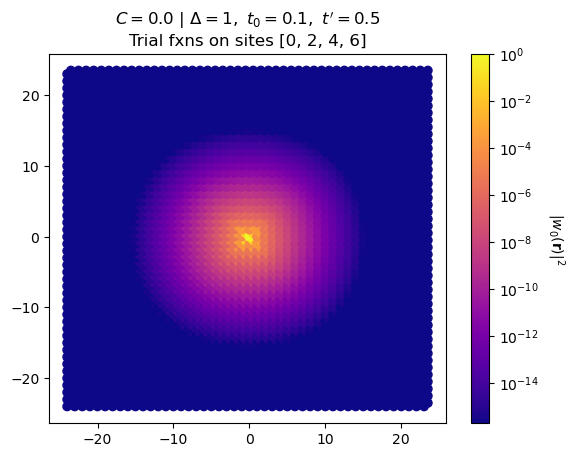

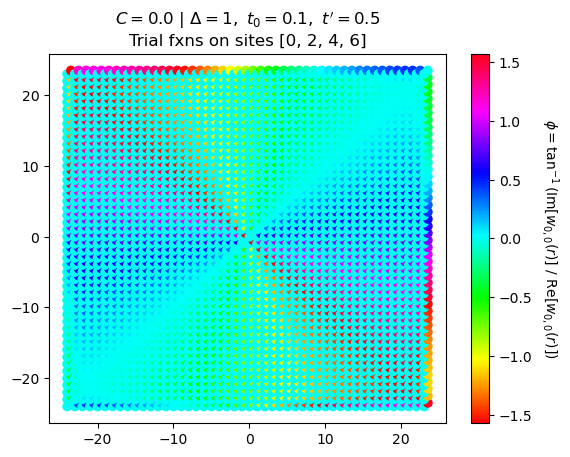

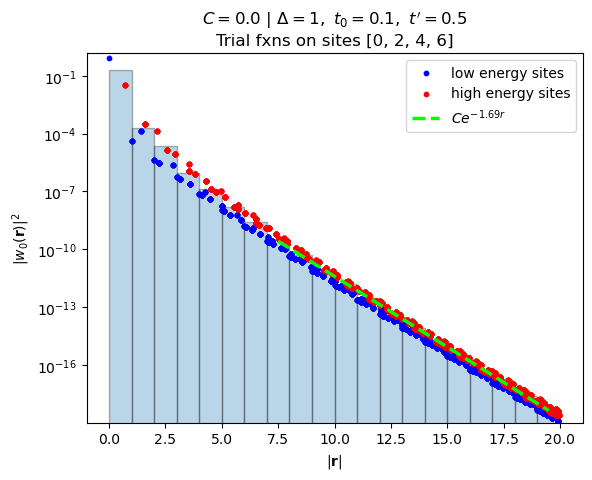

In [22]:
idx = 0
title = ( rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$"
             "\n" 
             rf"Trial fxns on sites {tf_list}")
save_name = f'w_{idx}_scatter_C={chern:.1f}_Delta={delta}_t0={t0}_tp={tprime}_tfxs={tf_list}.png'

plot.plot_Wan(w0, idx, orbs, lat_vecs, title=title, plot_phase=True, plot_decay=True, fit_rng=[7, 20])

## Computing spreads

#### Real space

In [10]:
spread, expc_rsq, expc_r_sq = spread_real(w0, orbs, lat_vecs, decomp=True)

KeyboardInterrupt: 

In [ ]:
print(f"Real space spread: {spread[0]: .11f}")
print(f"Real space <r^2> = {expc_rsq: .11f}")
print(f"Real space <r>^2 = {expc_r_sq: .11f}")
print(rf"Omega_I = {spread[1]: .11f}")
print(rf"\tilde{{Omega}} = {spread[2]: .11f}")
print(rf"Omega_I + \tilde{{Omega}} = {spread[1] + spread[2]: .11f}" )

Real space spread:  0.32512713078-0.00000000000j
Real space <r^2> =  4.32512713078-0.00000000000j
Real space <r>^2 =  4.00000000000+0.00000000000j
Omega_I =  0.29651084565-0.00000000000j
\tilde{Omega} =  0.02861628513-0.00000000000j
Omega_I + \tilde{Omega} =  0.32512713078-0.00000000000j


#### Reciprocal space

In [10]:
# 2D k-mesh
num_NN = 4 # number of nearest neighbors in reciprocal lattice
lat_vecs = model.get_lat() # lattice vectors
G = 2*np.pi/lat_vecs[0][0] # reciprocal lattice vector
b = G / nkx  # spacing between allowed kx
b_vec = [np.array([b, 0]), np.array([0, b]), np.array([-b, 0]), np.array([0, -b])] # vectors connecting nearest neighbor k points
w_b = 1/(2*b**2) # finite difference weights for cubic lattice

In [11]:
# getting cell periodic psi_tildes
psi_wfs = get_bloch_wfs(model, u_wfs_Wan, k_mesh_flat)
psi_tilde = get_psi_tilde(psi_wfs, tf_list)
u_tilde = get_bloch_wfs(model, psi_tilde, k_mesh_flat, inverse=True)

M = k_overlap_mat(u_tilde, num_NN, orbs=model.get_orb())

In [12]:
spread, expc_rsq, expc_r_sq = spread_recip(M, w_b, b_vec, decomp=True)

In [13]:
print(f"Reciprocal space spread: {spread[0]: .8f}")
print(f"Reciprocal space <r^2> = {expc_rsq: .8f}")
print(f"Reciprocal space <r>^2 = {expc_r_sq: .8f}")
print(rf"Reciprocal space Omega_I = {spread[1]: .8f}")
print(rf"Reciprocal space \tilde{{Omega}} = {spread[2]: .8f}")
print(rf"Omega_I + \tilde{{Omega}} = {spread[1] + spread[2]: .8f}" )

Reciprocal space spread:  0.32476810+0.00000000j
Reciprocal space <r^2> =  4.32476810+0.00000000j
Reciprocal space <r>^2 =  4.00000000+0.00000000j
Reciprocal space Omega_I =  0.29616175
Reciprocal space \tilde{Omega} =  0.02860635+0.00000000j
Omega_I + \tilde{Omega} =  0.32476810+0.00000000j
